In [1]:
using Distributions

safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y

"""
    h_brunner_munzel(x, y)

この函数は, x < y のとき 1.0 を, x = y のとき 0.5 を, それら以外のとき 0.0 返す.
"""
h_brunner_munzel(x, y) = (x < y) + (x == y)/2

@doc raw"""
    phat_brunner_munzel(X, Y)

まず以下のようにおく:

```math
\begin{aligned}
&
H(x, y) = \begin{cases} 1 & (x < y) \\ 1/2 & (x = y) \\ 0 & (x > y), \end{cases}
\\ &
m = \mathrm{length}(X), \quad
n = \mathrm{length}(Y), \quad
x_i = X[i], \quad
y_j = Y[j]
\end{aligned}
```

この函数は次の $\hat{p}$ を返す:

```math
\hat{p} = \frac{1}{mn}\sum_{i=1}^m \sum_{j=1}^n H(x_i, y_j).
```
"""
phat_brunner_munzel(X, Y) = mean(h_brunner_munzel(x, y) for x in X, y in Y)

@doc raw"""
    statistics_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64);
        p = 1/2
    )

この函数はデータ `X`, `Y` について, Brunner-Munzel検定関係の統計量達を計算する. 詳細は以下の通り.

函数 $H(x, y)$ と $\hat{p}$, $H^x_i$, $H^y_j$, $\bar{H}^x$, $\bar{H}^y$ を次のように定める:

```math
\begin{aligned}
&
m = \mathrm{length}(X), \quad
n = \mathrm{length}(Y), \quad
x_i = X[i], \quad
y_j = Y[j],
\\ &
\hat{p} = \frac{1}{mn}\sum_{i=1}^m \sum_{j=1}^n H(x_i, y_j),
\\ &
H(x, y) = \begin{cases} 1 & (x < y) \\ 1/2 & (x = y) \\ 0 & (x > y), \end{cases}
\\ &
H^x_i = \sum_{j=1}^n H(y_j, x_i), \quad
H^y_j = \sum_{i=1}^m H(x_i, y_j),
\\ &
\bar{H}^x = \frac{1}{m} \sum_{i=1}^m H^x_i = n - n\hat{p},
\\ &
\bar{H}^y = \frac{1}{n} \sum_{j=1}^n H^y_j = m\hat{p}.
\end{aligned}
```

この函数は以下達の named tuple で返す:

```math
\begin{aligned}
&
\mathrm{phat} = 
\hat{p} = \frac{\bar{H}^y - \bar{H}^x + n}{m + n},
\\ &
\mathrm{sx2} =
\hat{\sigma}_x^2 = \frac{1}{n^2}\frac{1}{m-1}\sum_{i=1}^m (H^x_i - \bar{H}^x)^2,
\\ &
\mathrm{sy2} =
\hat{\sigma}_y^2 = \frac{1}{m^2}\frac{1}{n-1}\sum_{j=1}^n (H^y_j - \bar{H}^y)^2,
\\ &
\mathrm{sehat} = 
\widehat{\mathrm{se}} = \sqrt{\frac{\hat{\sigma}_x^2}{m} + \frac{\hat{\sigma}_y^2}{n}}, 
\\ &
\mathrm{tvalue} = t = \frac{\hat{p} - p}{\widehat{\mathrm{se}}},
\\ &
\mathrm{df} =
\nu = 
\frac
{\left(\hat{\sigma}_x^2/m + \hat{\sigma}_y^2/n\right)^2}
{
\dfrac{\left(\hat{\sigma}_x^2/m\right)^2}{m-1} +
\dfrac{\left(\hat{\sigma}_y^2/n\right)^2}{n-1}
},
\\ &
\mathrm{pvalue} =
2\mathrm{ccdf}(\mathrm{TDist}(\nu), |t|).
\end{aligned}
```
"""
function statistics_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64);
        p = 1/2
    )
    m, n = length(X), length(Y)
    for (i, x) in pairs(X)
        Hx[i] = sum(h_brunner_munzel(y, x) for y in Y)
    end
    for (j, y) in pairs(Y)
        Hy[j] = sum(h_brunner_munzel(x, y) for x in X)
    end
    phat = (mean(Hy) - mean(Hx) + n)/(m + n)
    sx2, sy2 = var(Hx)/n^2, var(Hy)/m^2
    sehat = √(sx2/m + sy2/n)
    tvalue = (phat - p)/sehat
    df = safediv((sx2/m + sy2/n)^2, (sx2/m)^2/(m-1) + (sy2/n)^2/(n-1))
    pvalue = (df != 0 && isfinite(df)) ? 2ccdf(TDist(df), abs(tvalue)) : zero(df)
    (; phat, sx2, sy2, sehat, tvalue, df, pvalue)
end

@doc raw"""
    pvalue_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64);
        p = 1/2
    )

この函数はBrunner-Munzel検定のP値 `pvalue` を返す.
"""
function pvalue_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64);
        p = 1/2
    )
    statistics_brunner_munzel(X, Y, Hx, Hy; p).pvalue
end

"""
    tieshift(X::AbstractVector, Y::AbstractVector; p = 1/2)

この函数は `phat_brunner_munzel(X, Y .+ a)` の値が `p` に等しくなる `a` を返す.
"""
function tieshift(X::AbstractVector, Y::AbstractVector; p = 1/2)
    shiftmin = minimum(X) - maximum(Y) - 0.1
    shiftmax = maximum(X) - minimum(Y) + 0.1
    find_zero(a -> phat_brunner_munzel(X, Y .+ a) - p, (shiftmin, shiftmax))
end

@doc raw"""
    brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64),
        Ytmp = similar(Y, Float64);
        p = 1/2,
        α = 0.05,
        maxsplit = 30
    )

この函数はBrunner-Munzel検定を実行する. 詳細は以下の通り.

この函数は `phat`, `sehat`, `tvalue`, `df`, `p`, `pvalue`, `α` および\
以下達の named tuple を返す.

```math
\begin{aligned}
&
\mathrm{confint\_p} = (\text{$p$ の信頼度 $1-\alpha$ の信頼区間}),
\\ &
\mathrm{confint\_shift} = (\text{2つの集団が互角になるようなシフトの信頼度 $1-\alpha$ の信頼区間}),
\\ &
\mathrm{pvalue\_shift} = ($\mathrm{confint\_shift}$ の計算で使われたP値函数),
\\ &
\mathrm{shifthat} = (\text{2つの集団が互角になるようなシフトの点推定値}).
\end{aligned}
```

さらに, $\mathrm{shiftmin}$, $\mathrm{shiftmax}$ はデータから推定されるシフトの下限と上限.

"""
function brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64),
        Ytmp = similar(Y, Float64);
        p = 1/2,
        α = 0.05,
        maxsplit = 30
    )
    (; phat, sehat, tvalue, df, pvalue) = statistics_brunner_munzel(X, Y, Hx, Hy; p)
    
    c = df == 0 ? Inf : quantile(TDist(df), 1 - α/2)
    confint_p = [max(0, phat - c*sehat), min(1, phat + c*sehat)]
    
    function pvalue_shift(a)
        @. Ytmp = Y + a
        pvalue_brunner_munzel(X, Ytmp, Hx, Hy; p)
    end
    shiftmin = minimum(X) - maximum(Y) - 0.1
    shiftmax = maximum(X) - minimum(Y) + 0.1
    shifthat = tieshift(X, Y; p)
    confint_shift = [
        find_zero(a -> pvalue_shift(a) - α, (shiftmin, shifthat))
        find_zero(a -> pvalue_shift(a) - α, (shifthat, shiftmax))
    ]
    
    (; phat, sehat, tvalue, df, p, pvalue, α, confint_p,
        confint_shift, pvalue_shift, shifthat, shiftmin, shiftmax)
end

function show_plot_brunner_munzel(X, Y,
        Hx = similar(X, Float64),
        Hy = similar(Y, Float64),
        Ytmp = similar(Y, Float64);
        p = 1/2,
        α = 0.05,
        showXY = false,
        kwargs...
    )
    showXY && (@show X Y)
    (; phat, sehat, tvalue, df, p, pvalue, α, confint_p, 
        confint_shift, pvalue_shift, shifthat, shiftmin, shiftmax) =
        brunner_munzel(X, Y, Hx, Hy, Ytmp; p, α)
    pprint((; phat, sehat, tvalue, df, p, pvalue, α, confint_p,
            confint_shift, shifthat))
    println()
    @show median(X) median(Y)
    plot(pvalue_shift, shiftmin, shiftmax; label="")
    vline!([tieshift(X, Y)]; label="", ls=:dash)    
    title!("P-value function of shift")
    plot!(ytick=0:0.05:1)
    plot!(; kwargs...)
end

show_plot_brunner_munzel (generic function with 4 methods)

In [2]:
@doc statistics_brunner_munzel

```
statistics_brunner_munzel(X, Y,
    Hx = similar(X, Float64),
    Hy = similar(Y, Float64);
    p = 1/2
)
```

この函数はデータ `X`, `Y` について, Brunner-Munzel検定関係の統計量達を計算する. 詳細は以下の通り.

函数 $H(x, y)$ と $\hat{p}$, $H^x_i$, $H^y_j$, $\bar{H}^x$, $\bar{H}^y$ を次のように定める:

$$
\begin{aligned}
&
m = \mathrm{length}(X), \quad
n = \mathrm{length}(Y), \quad
x_i = X[i], \quad
y_j = Y[j],
\\ &
\hat{p} = \frac{1}{mn}\sum_{i=1}^m \sum_{j=1}^n H(x_i, y_j),
\\ &
H(x, y) = \begin{cases} 1 & (x < y) \\ 1/2 & (x = y) \\ 0 & (x > y), \end{cases}
\\ &
H^x_i = \sum_{j=1}^n H(y_j, x_i), \quad
H^y_j = \sum_{i=1}^m H(x_i, y_j),
\\ &
\bar{H}^x = \frac{1}{m} \sum_{i=1}^m H^x_i = n - n\hat{p},
\\ &
\bar{H}^y = \frac{1}{n} \sum_{j=1}^n H^y_j = m\hat{p}.
\end{aligned}
$$

この函数は以下達の named tuple で返す:

$$
\begin{aligned}
&
\mathrm{phat} = 
\hat{p} = \frac{\bar{H}^y - \bar{H}^x + n}{m + n},
\\ &
\mathrm{sx2} =
\hat{\sigma}_x^2 = \frac{1}{n^2}\frac{1}{m-1}\sum_{i=1}^m (H^x_i - \bar{H}^x)^2,
\\ &
\mathrm{sy2} =
\hat{\sigma}_y^2 = \frac{1}{m^2}\frac{1}{n-1}\sum_{j=1}^n (H^y_j - \bar{H}^y)^2,
\\ &
\mathrm{sehat} = 
\widehat{\mathrm{se}} = \sqrt{\frac{\hat{\sigma}_x^2}{m} + \frac{\hat{\sigma}_y^2}{n}}, 
\\ &
\mathrm{tvalue} = t = \frac{\hat{p} - p}{\widehat{\mathrm{se}}},
\\ &
\mathrm{df} =
\nu = 
\frac
{\left(\hat{\sigma}_x^2/m + \hat{\sigma}_y^2/n\right)^2}
{
\dfrac{\left(\hat{\sigma}_x^2/m\right)^2}{m-1} +
\dfrac{\left(\hat{\sigma}_y^2/n\right)^2}{n-1}
},
\\ &
\mathrm{pvalue} =
2\mathrm{ccdf}(\mathrm{TDist}(\nu), |t|).
\end{aligned}
$$


In [3]:
using Distributions

safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y

"""
    h_brunner_munzel(x, y)

この函数は, x < y のとき 1.0 を, x = y のとき 0.5 を, それら以外のとき 0.0 返す.
"""
h_brunner_munzel(x, y) = (x < y) + (x == y)/2

@doc raw"""
    brunner_munzel_test(X, Y; p = 1/2)

この函数は数値のベクトルのデータ `X`, `Y` について, Brunner-Munzel検定関係の統計量達を計算する. 詳細は以下の通り.

函数 $H(x, y)$ と $\hat{p}$, $H^x_i$, $H^y_j$, $\bar{H}^x$, $\bar{H}^y$ を次のように定める:

```math
\begin{aligned}
&
m = \mathrm{length}(X), \quad
n = \mathrm{length}(Y), \quad
x_i = X[i], \quad
y_j = Y[j],
\\ &
\hat{p} = \frac{1}{mn}\sum_{i=1}^m \sum_{j=1}^n H(x_i, y_j),
\\ &
H(x, y) = \begin{cases} 1 & (x < y) \\ 1/2 & (x = y) \\ 0 & (x > y), \end{cases}
\\ &
H^x_i = \sum_{j=1}^n H(y_j, x_i), \quad
H^y_j = \sum_{i=1}^m H(x_i, y_j),
\\ &
\bar{H}^x = \frac{1}{m} \sum_{i=1}^m H^x_i = n - n\hat{p},
\\ &
\bar{H}^y = \frac{1}{n} \sum_{j=1}^n H^y_j = m\hat{p}.
\end{aligned}
```

この函数は以下達の named tuple で返す:

```math
\begin{aligned}
&
\mathrm{phat} = 
\hat{p} = \frac{\bar{H}^y - \bar{H}^x + n}{m + n},
\\ &
\mathrm{sx2} =
\hat{\sigma}_x^2 = \frac{1}{n^2}\frac{1}{m-1}\sum_{i=1}^m (H^x_i - \bar{H}^x)^2,
\\ &
\mathrm{sy2} =
\hat{\sigma}_y^2 = \frac{1}{m^2}\frac{1}{n-1}\sum_{j=1}^n (H^y_j - \bar{H}^y)^2,
\\ &
\mathrm{sehat} = 
\widehat{\mathrm{se}} = \sqrt{\frac{\hat{\sigma}_x^2}{m} + \frac{\hat{\sigma}_y^2}{n}}, 
\\ &
\mathrm{tvalue} = t = \frac{\hat{p} - p}{\widehat{\mathrm{se}}},
\\ &
\mathrm{df} =
\nu = 
\frac
{\left(\hat{\sigma}_x^2/m + \hat{\sigma}_y^2/n\right)^2}
{
\dfrac{\left(\hat{\sigma}_x^2/m\right)^2}{m-1} +
\dfrac{\left(\hat{\sigma}_y^2/n\right)^2}{n-1}
},
\\ &
\mathrm{pvalue} =
2\mathrm{ccdf}(\mathrm{TDist}(\nu), |t|),
\\ &
\mathrm{p} = p.
\end{aligned}
```
"""
function brunner_munzel_test(X, Y; p=1/2)
    m, n = length(X), length(Y)
    phat = mean(h_brunner_munzel(x, y) for x in X, y in Y)
    Hbarx = n*(1 - phat)
    Hbary = m*phat
    sx2 = 1/n^2 * 1/(m-1) * sum((sum(h_brunner_munzel(y, x) for y in Y) - Hbarx)^2 for x in X)
    sy2 = 1/m^2 * 1/(n-1) * sum((sum(h_brunner_munzel(x, y) for x in X) - Hbary)^2 for y in Y)
    sehat = √(sx2/m + sy2/n)
    tvalue = (phat - p)/sehat
    df = (sx2/m + sy2/n)^2 / ((sx2/m)^2/(m-1) + (sy2/n)^2/(n-1))
    pvalue = 2ccdf(TDist(df), abs(tvalue))
    (; phat, sehat, tvalue, df, pvalue, p)
end

@doc raw"""
    pvalue_brunner_munzel(X, Y; p = 1/2)

この函数はBrunner-Munzel検定のP値 `pvalue` を返す.
"""
pvalue_brunner_munzel_test(X, Y; p=1/2) = brunner_munzel_test(X, Y; p).pvalue

pvalue_brunner_munzel_test

In [4]:
X = rand(30) .+ 0.3
Y = rand(20)

p = 0.3
(; phat, sehat, tvalue, df, pvalue) = statistics_brunner_munzel(X, Y; p)
A = [phat, sehat, tvalue, df, pvalue, p]
(; phat, sehat, tvalue, df, pvalue, p) =brunner_munzel_test(X, Y; p)
B = [phat, sehat, tvalue, df, pvalue, p]
@show A ≈ B
[A B]

A ≈ B = true


6×2 Matrix{Float64}:
  0.191667    0.191667
  0.0626927   0.0626927
 -1.728      -1.728
 36.372      36.372
  0.0924703   0.0924703
  0.3         0.3

In [5]:
@doc h_brunner_munzel

```
h_brunner_munzel(x, y)
```

この函数は, x < y のとき 1.0 を, x = y のとき 0.5 を, それら以外のとき 0.0 返す.


In [6]:
@doc brunner_munzel_test

```
brunner_munzel_test(X, Y; p = 1/2)
```

この函数は数値のベクトルのデータ `X`, `Y` について, Brunner-Munzel検定関係の統計量達を計算する. 詳細は以下の通り.

函数 $H(x, y)$ と $\hat{p}$, $H^x_i$, $H^y_j$, $\bar{H}^x$, $\bar{H}^y$ を次のように定める:

$$
\begin{aligned}
&
m = \mathrm{length}(X), \quad
n = \mathrm{length}(Y), \quad
x_i = X[i], \quad
y_j = Y[j],
\\ &
\hat{p} = \frac{1}{mn}\sum_{i=1}^m \sum_{j=1}^n H(x_i, y_j),
\\ &
H(x, y) = \begin{cases} 1 & (x < y) \\ 1/2 & (x = y) \\ 0 & (x > y), \end{cases}
\\ &
H^x_i = \sum_{j=1}^n H(y_j, x_i), \quad
H^y_j = \sum_{i=1}^m H(x_i, y_j),
\\ &
\bar{H}^x = \frac{1}{m} \sum_{i=1}^m H^x_i = n - n\hat{p},
\\ &
\bar{H}^y = \frac{1}{n} \sum_{j=1}^n H^y_j = m\hat{p}.
\end{aligned}
$$

この函数は以下達の named tuple で返す:

$$
\begin{aligned}
&
\mathrm{phat} = 
\hat{p} = \frac{\bar{H}^y - \bar{H}^x + n}{m + n},
\\ &
\mathrm{sx2} =
\hat{\sigma}_x^2 = \frac{1}{n^2}\frac{1}{m-1}\sum_{i=1}^m (H^x_i - \bar{H}^x)^2,
\\ &
\mathrm{sy2} =
\hat{\sigma}_y^2 = \frac{1}{m^2}\frac{1}{n-1}\sum_{j=1}^n (H^y_j - \bar{H}^y)^2,
\\ &
\mathrm{sehat} = 
\widehat{\mathrm{se}} = \sqrt{\frac{\hat{\sigma}_x^2}{m} + \frac{\hat{\sigma}_y^2}{n}}, 
\\ &
\mathrm{tvalue} = t = \frac{\hat{p} - p}{\widehat{\mathrm{se}}},
\\ &
\mathrm{df} =
\nu = 
\frac
{\left(\hat{\sigma}_x^2/m + \hat{\sigma}_y^2/n\right)^2}
{
\dfrac{\left(\hat{\sigma}_x^2/m\right)^2}{m-1} +
\dfrac{\left(\hat{\sigma}_y^2/n\right)^2}{n-1}
},
\\ &
\mathrm{pvalue} =
2\mathrm{ccdf}(\mathrm{TDist}(\nu), |t|),
\\ &
\mathrm{p} = p.
\end{aligned}
$$


In [7]:
@doc pvalue_brunner_munzel_test

```
pvalue_brunner_munzel(X, Y; p = 1/2)
```

この函数はBrunner-Munzel検定のP値 `pvalue` を返す.


In [8]:
using Distributions

safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y

h_brunner_munzel(x, y) = (x < y) + (x == y)/2

function brunner_munzel_test(X, Y; p=1/2)
    m, n = length(X), length(Y)
    phat = mean(h_brunner_munzel(x, y) for x in X, y in Y)
    Hbarx = n*(1 - phat)
    Hbary = m*phat
    sx2 = 1/n^2 * 1/(m-1) * sum((sum(h_brunner_munzel(y, x) for y in Y) - Hbarx)^2 for x in X)
    sy2 = 1/m^2 * 1/(n-1) * sum((sum(h_brunner_munzel(x, y) for x in X) - Hbary)^2 for y in Y)
    sehat = √(sx2/m + sy2/n)
    tvalue = safediv(phat - p, sehat)
    df = safediv((sx2/m + sy2/n)^2, (sx2/m)^2/(m-1) + (sy2/n)^2/(n-1))
    pvalue = df == 0 ? 1.0 : 2ccdf(TDist(df), abs(tvalue))
    (; phat, sehat, tvalue, df, pvalue, p)
end

pvalue_brunner_munzel_test(X, Y; p=1/2) = brunner_munzel_test(X, Y; p).pvalue

pvalue_brunner_munzel_test (generic function with 1 method)

In [9]:
X = rand(Normal(0, 1), 30)
Y = rand(Normal(0, 1), 20)
brunner_munzel_test(X, Y)

(phat = 0.44666666666666666, sehat = 0.08238504612956968, tvalue = -0.6473666744017386, df = 47.921205112236606, pvalue = 0.5204839617145516, p = 0.5)

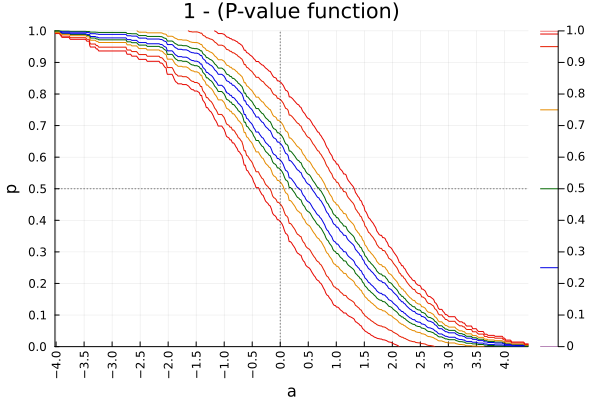

In [10]:
using StatsPlots
default(fmt=:png)

f(X, Y, a, p) = 1 - pvalue_brunner_munzel_test(X .+ a, Y; p)

X = rand(Normal(0, 1), 30)
Y = rand(Normal(0, 1), 20)

ps = range(0, 1, 401)
as = range(minimum(Y) - maximum(X) + 0.1, maximum(Y) - minimum(X) - 0.1, 401)
levels = [0, 0.25, 0.5, 0.75, 0.95, 0.99, 1]
contour(as, ps, (a, p) -> f(X, Y, a, p); levels, color=:darkrainbow)
vline!([0.0]; label="", ls=:dot, c=:black, alpha=0.5)
hline!([0.5]; label="", ls=:dot, c=:black, alpha=0.5)
plot!(xtick=-5:0.5:5, ytick=0:0.1:1, xrotation=90)
plot!(xguide="a", yguide="p")
title!("1 - (P-value function)")

In [11]:
using QuadGK

function winningrate(
        distx::ContinuousUnivariateDistribution,
        disty::ContinuousUnivariateDistribution
    )
    quadgk(y -> cdf(distx, y)*pdf(disty, y), extrema(disty)...)[1]
end

winningrate(Exponential() - 1, 1.1*(Exponential() - 1))

0.47829085338031047

In [12]:
using Roots

function tieshift(
        distx::ContinuousUnivariateDistribution,
        disty::ContinuousUnivariateDistribution;
        p = 0.5
    )
    find_zero(0.0) do a
        winningrate(distx + a, disty) - p
    end
end

@show a = tieshift(Exponential() - 1, 1.1*(Exponential() - 1))
winningrate(Exponential() - 1 + a, 1.1*(Exponential() - 1))

a = tieshift(Exponential() - 1, 1.1 * (Exponential() - 1)) = -0.04882798316870562


0.49999999999999994

distx = Exponential(1) = Exponential{Float64}(θ=1.0)
disty = 3distx = LocationScale{Float64, Continuous, Exponential{Float64}}(
μ: 0.0
σ: 3.0
ρ: Exponential{Float64}(θ=1.0)
)

ts = tieshift(distx, disty) = 1.2163953243549488
distx = distx + ts = LocationScale{Float64, Continuous, Exponential{Float64}}(
μ: 1.2163953243549488
σ: 1.0
ρ: Exponential{Float64}(θ=1.0)
)

winningrate(distx, disty) = 0.5
mean(distx) = 2.2163953243549486
mean(disty) = 3.0
median(distx) = 1.909542504914894
median(disty) = 2.0794415416798357


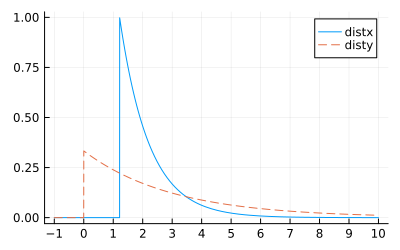

m = 100 = 100
n = 100 = 100

α = 0.05 = 0.05
ECDF(pval_bm, α) = 0.050882
ECDF(pval_mw, α) = 0.070137


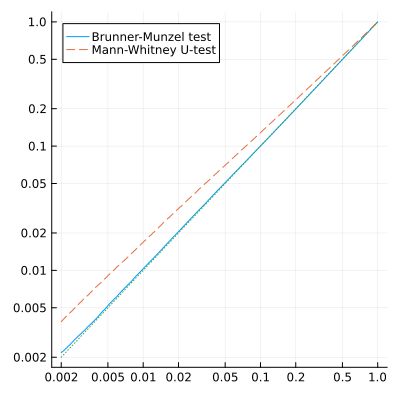

In [13]:
using HypothesisTests
ECDF(A, x) = count(≤(x), A)/length(A)

@show distx = Exponential(1)
@show disty = 3distx
@show ts = tieshift(distx, disty)
@show distx = distx + ts
@show winningrate(distx, disty)
@show mean(distx) mean(disty)
@show median(distx) median(disty)

a, b = -1, 10
plot(distx, a, b; label="distx")
plot!(disty, a, b; label="disty", ls=:dash)
plot!(xtick=-10:10, size=(400, 250))
plot!() |> display

@show m = 100
@show n = 100
println()

L = 10^6
pval_bm = zeros(L)
pval_mw = zeros(L)

Threads.@threads for i in 1:L
    X = rand(distx, m)
    Y = rand(disty, n)
    pval_bm[i] = pvalue_brunner_munzel(X, Y)
    pval_mw[i] = HypothesisTests.pvalue(MannWhitneyUTest(X, Y))
end

@show α = 0.05
@show ECDF(pval_bm, α)
@show ECDF(pval_mw, α)

_tick = [0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
xtick = ytick = (_tick, string.(_tick))

αs = exp.(range(log(0.002), log(1), 1000))
plot(αs, α -> ECDF(pval_bm, α); label="Brunner-Munzel test")
plot!(αs, α -> ECDF(pval_mw, α); label="Mann-Whitney U-test", ls=:dash)
plot!(αs, identity; label="", ls=:dot)
plot!(; xscale=:log10, yscale=:log10, xtick, ytick)
plot!(size=(400, 400))

distx = Normal(0, 1) = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal(0, 3) = Normal{Float64}(μ=0.0, σ=3.0)
mean(distx) = 0.0
mean(disty) = 0.0


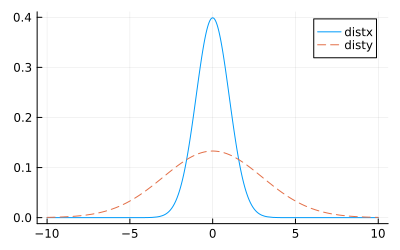

m = 50 = 50
n = 50 = 50

α = 0.05 = 0.05
ECDF(pval_bm, α) = 0.050316
ECDF(pval_mw, α) = 0.068243


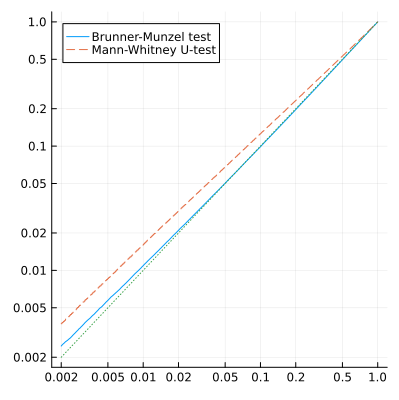

In [16]:
using HypothesisTests
ECDF(A, x) = count(≤(x), A)/length(A)

@show distx = Normal(0, 1)
@show disty = Normal(0, 3)
@show mean(distx) mean(disty)

a, b = -10, 10
plot(distx, a, b; label="distx")
plot!(disty, a, b; label="disty", ls=:dash)
plot!(size=(400, 250))
plot!() |> display

@show m = 50
@show n = 50
println()

L = 10^6
pval_bm = zeros(L)
pval_mw = zeros(L)

Threads.@threads for i in 1:L
    X = rand(distx, m)
    Y = rand(disty, n)
    pval_bm[i] = pvalue_brunner_munzel(X, Y)
    pval_mw[i] = HypothesisTests.pvalue(MannWhitneyUTest(X, Y))
end

@show α = 0.05
@show ECDF(pval_bm, α)
@show ECDF(pval_mw, α)

_tick = [0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
xtick = ytick = (_tick, string.(_tick))

αs = exp.(range(log(0.002), log(1), 1000))
plot(αs, α -> ECDF(pval_bm, α); label="Brunner-Munzel test")
plot!(αs, α -> ECDF(pval_mw, α); label="Mann-Whitney U-test", ls=:dash)
plot!(αs, identity; label="", ls=:dot)
plot!(; xscale=:log10, yscale=:log10, xtick, ytick)
plot!(size=(400, 400))